In [48]:
# Manipulation des données
import pandas as pd
import re

# Traitement de texte et NLP
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import dateparser

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Modélisation thématique (Topic Modeling)
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model

# Optimisation hyperparamètres
import optuna

# Sauvegarde et chargement de modèles
import joblib

# Utilitaires
from collections import Counter
from sklearn.model_selection import train_test_split


In [49]:
df = pd.read_csv("C:/Users/Ahmed Firhoun/Desktop/senego_scrapper/articles_scraped.csv")
df.head()

,source,theme,titre,date,date_parsed,auteur,contenu,url
0,Senego,Sport,Guinée : la FEGUIFOOT conteste la décision de ...,"17 juin 2025, 06:30",2025-06-17,Abdou Nar Dia,La Fédération Guinéenne de Football (FEGUIFOOT...,https://senego.com/guinee-la-feguifoot-contest...
1,SeneNews,Actualité,Conflit Israël-Iran : Le Sénégal prend officie...,16/06/2025 à 23:42,2025-06-16 23:42,Barry Souleymane,"Dans ce communiqué officiel, les autorités sén...",https://www.senenews.com/actualites/politique/...
2,SeneNews,Actualité,Conflit avec Israël : L’Iran annonce avoir bom...,16/06/2025 à 22:40,2025-06-16 22:40,Barry Souleymane,La tension reste vive au Moyen-Orient. Selon u...,https://www.senenews.com/actualites/conflit-av...
3,SeneNews,Education,"Ameth Babou, du Prytanée militaire, meilleur é...",16/06/2025 à 22:30,2025-06-16 22:30,Kabir Sall,Ameth Babou du Prytanée militaire de Saint-Lou...,https://www.senenews.com/actualites/ameth-babo...
4,SeneNews,International,Conflit Iran-Israël : la Chine exprime sa « pr...,16/06/2025 à 22:18,2025-06-16 22:18,Barry Souleymane,LaChinea exprimé ce lundi sa « profonde préocc...,https://www.senenews.com/actualites/politique/...


In [50]:
import pandas as pd
df = pd.read_csv('articles_scraped.csv')
print(f"Total lignes: {len(df)}")
print(f"Lignes avec contenu non-null: {len(df.dropna(subset=['contenu']))}")
print(f"Lignes avec contenu vide/null:")
print(df[df['contenu'].isna()].shape[0])
print(f"Types de données dans 'contenu':")
print(df['contenu'].dtype)
print(f"Premières valeurs nulles si elles existent:")
print(df[df['contenu'].isna()].head())
print(f"Lignes avec contenu vide après strip: {len(df[df['contenu'].astype(str).str.strip() == ''])}")

Total lignes: 637
Lignes avec contenu non-null: 605
Lignes avec contenu vide/null:
32
Types de données dans 'contenu':
object
Premières valeurs nulles si elles existent:
      source          theme  \
11  SeneNews      Actualité   
15  SeneNews      Actualité   
23  SeneNews      Actualité   
40  SeneNews      Politique   
42  SeneNews  International   

                                                titre                date  \
11  BÉTÉ BÉTÉ – Saison 2 – Episode 54 – décryptage...  16/06/2025 à 20:24   
15  « Bavure policière » : le collectif Noo Lank e...  16/06/2025 à 19:31   
23  Fatick : Cambriolage et incendie d’une cantine...  16/06/2025 à 17:40   
40  Bassirou Diomaye Faye et Tété António, zoom su...  16/06/2025 à 13:59   
42  Gaza : L’armée israélienne tue 20 personnes qu...  16/06/2025 à 13:39   

         date_parsed              auteur contenu  \
11  2025-06-16 20:24    Barry Souleymane     NaN   
15  2025-06-16 19:31          Kabir Sall     NaN   
23  2025-06-16 17:40    

# 1.Exploration des données

## 1.1 Types des variables

In [51]:
df.dtypes

source         object
theme          object
titre          object
date           object
date_parsed    object
auteur         object
contenu        object
url            object
dtype: object

In [52]:
def parse_mixed_datetime(date_str):
    return dateparser.parse(date_str, languages=['fr'])

df['date'] = df['date'].apply(parse_mixed_datetime)
df['date_parsed'] = df['date_parsed'].apply(parse_mixed_datetime)
df.dtypes

source                 object
theme                  object
titre                  object
date           datetime64[ns]
date_parsed    datetime64[ns]
auteur                 object
contenu                object
url                    object
dtype: object

## 1.2 Description

In [53]:
df.head()

,source,theme,titre,date,date_parsed,auteur,contenu,url
0,Senego,Sport,Guinée : la FEGUIFOOT conteste la décision de ...,2025-06-17 06:30:00,NaT,Abdou Nar Dia,La Fédération Guinéenne de Football (FEGUIFOOT...,https://senego.com/guinee-la-feguifoot-contest...
1,SeneNews,Actualité,Conflit Israël-Iran : Le Sénégal prend officie...,2025-06-16 23:42:00,NaT,Barry Souleymane,"Dans ce communiqué officiel, les autorités sén...",https://www.senenews.com/actualites/politique/...
2,SeneNews,Actualité,Conflit avec Israël : L’Iran annonce avoir bom...,2025-06-16 22:40:00,NaT,Barry Souleymane,La tension reste vive au Moyen-Orient. Selon u...,https://www.senenews.com/actualites/conflit-av...
3,SeneNews,Education,"Ameth Babou, du Prytanée militaire, meilleur é...",2025-06-16 22:30:00,NaT,Kabir Sall,Ameth Babou du Prytanée militaire de Saint-Lou...,https://www.senenews.com/actualites/ameth-babo...
4,SeneNews,International,Conflit Iran-Israël : la Chine exprime sa « pr...,2025-06-16 22:18:00,NaT,Barry Souleymane,LaChinea exprimé ce lundi sa « profonde préocc...,https://www.senenews.com/actualites/politique/...


In [54]:
df.describe(include='all')

,source,theme,titre,date,date_parsed,auteur,contenu,url
count,637,637,637,637,312,637,605,637
unique,2,13,636,NaN,NaN,20,598,637
top,SeneNews,Actualité,Etats-Unis : Les raisons de l’annulation du vo...,NaN,NaN,Faty BA,Pourquoi vous devez soutenir l’initiative Sene...,https://senego.com/guinee-la-feguifoot-contest...
freq,333,159,2,NaN,NaN,106,8,1
mean,NaN,NaN,NaN,2025-06-13 03:57:18.367346944,2025-10-25 05:29:01.153846016,NaN,NaN,NaN
min,NaN,NaN,NaN,2025-06-07 08:50:00,2025-07-06 00:00:00,NaN,NaN,NaN
25%,NaN,NaN,NaN,2025-06-11 15:49:00,2025-10-06 00:00:00,NaN,NaN,NaN
50%,NaN,NaN,NaN,2025-06-13 08:21:00,2025-11-06 00:00:00,NaN,NaN,NaN
75%,NaN,NaN,NaN,2025-06-14 18:06:00,2025-12-06 00:00:00,NaN,NaN,NaN
max,NaN,NaN,NaN,2025-06-17 06:30:00,2025-12-06 23:51:00,NaN,NaN,NaN


In [55]:
df.head()

,source,theme,titre,date,date_parsed,auteur,contenu,url
0,Senego,Sport,Guinée : la FEGUIFOOT conteste la décision de ...,2025-06-17 06:30:00,NaT,Abdou Nar Dia,La Fédération Guinéenne de Football (FEGUIFOOT...,https://senego.com/guinee-la-feguifoot-contest...
1,SeneNews,Actualité,Conflit Israël-Iran : Le Sénégal prend officie...,2025-06-16 23:42:00,NaT,Barry Souleymane,"Dans ce communiqué officiel, les autorités sén...",https://www.senenews.com/actualites/politique/...
2,SeneNews,Actualité,Conflit avec Israël : L’Iran annonce avoir bom...,2025-06-16 22:40:00,NaT,Barry Souleymane,La tension reste vive au Moyen-Orient. Selon u...,https://www.senenews.com/actualites/conflit-av...
3,SeneNews,Education,"Ameth Babou, du Prytanée militaire, meilleur é...",2025-06-16 22:30:00,NaT,Kabir Sall,Ameth Babou du Prytanée militaire de Saint-Lou...,https://www.senenews.com/actualites/ameth-babo...
4,SeneNews,International,Conflit Iran-Israël : la Chine exprime sa « pr...,2025-06-16 22:18:00,NaT,Barry Souleymane,LaChinea exprimé ce lundi sa « profonde préocc...,https://www.senenews.com/actualites/politique/...


## 1.3 Valeurs manquantes

In [56]:
# Nombre de NA par variable
na_counts = df.isna().sum()

# Afficher le résultat
print(na_counts)

source           0
theme            0
titre            0
date             0
date_parsed    325
auteur           0
contenu         32
url              0
dtype: int64


In [57]:
df = df.dropna(subset=['contenu'])
df = df.drop(columns=['date_parsed'])
# Nombre de NA par variable
na_counts = df.isna().sum()

# Afficher le résultat
print(na_counts)

source     0
theme      0
titre      0
date       0
auteur     0
contenu    0
url        0
dtype: int64


## 1.1 Articles par rubriques

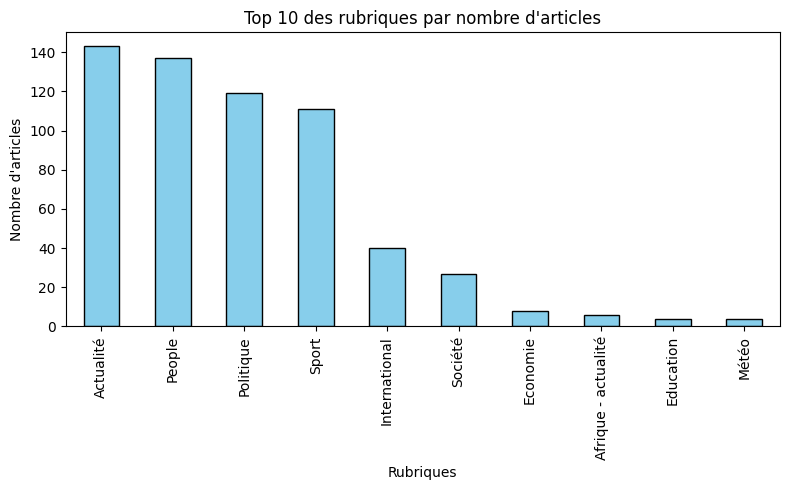

In [58]:
compte_rubrique = df['theme'].value_counts().head(10)

# Afficher le graphique
plt.figure(figsize=(8, 5))
compte_rubrique.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 des rubriques par nombre d'articles")
plt.xlabel("Rubriques")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

## 1.2 Articles par auteurs

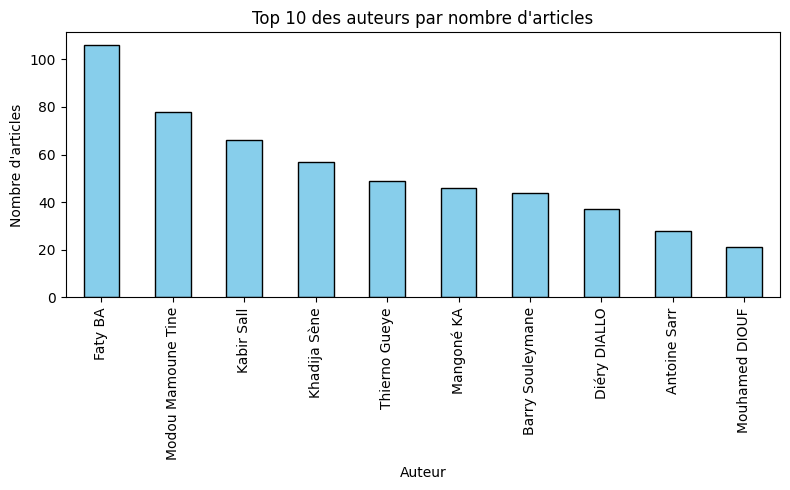

In [59]:
compte_auteurs = df['auteur'].value_counts().head(10)
plt.figure(figsize=(8, 5))
compte_auteurs.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 des auteurs par nombre d'articles")
plt.xlabel("Auteur")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

## 1.2 Article le plus récent

In [60]:
article_recent = df.loc[df['date'].idxmax()]

print("Article le plus récent :\n")
print(f"Titre     : {article_recent['titre']}")
print(f"Auteur    : {article_recent['auteur']}")
print(f"Date      : {article_recent['date']}")
print(f"Rubrique  : {article_recent['theme']}")
print(f"Source    : {article_recent['source']}")
print(f"URL       : {article_recent['url']}")


Article le plus récent :

Titre     : Guinée : la FEGUIFOOT conteste la décision de la CAF devant le TAS.
Auteur    : Abdou Nar Dia
Date      : 2025-06-17 06:30:00
Rubrique  : Sport
Source    : Senego
URL       : https://senego.com/guinee-la-feguifoot-conteste-la-decision-de-la-caf-devant-le-tas_1849513.html


## 1.4 Articles par sources

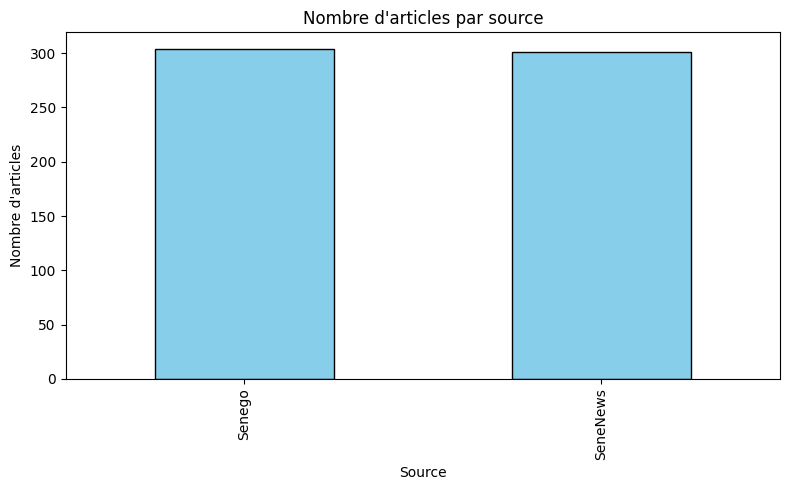

In [61]:

compte_source = df['source'].value_counts()
plt.figure(figsize=(8, 5))
compte_source.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'articles par source")
plt.xlabel("Source")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

## 1.5 Nombre d'articles par jour

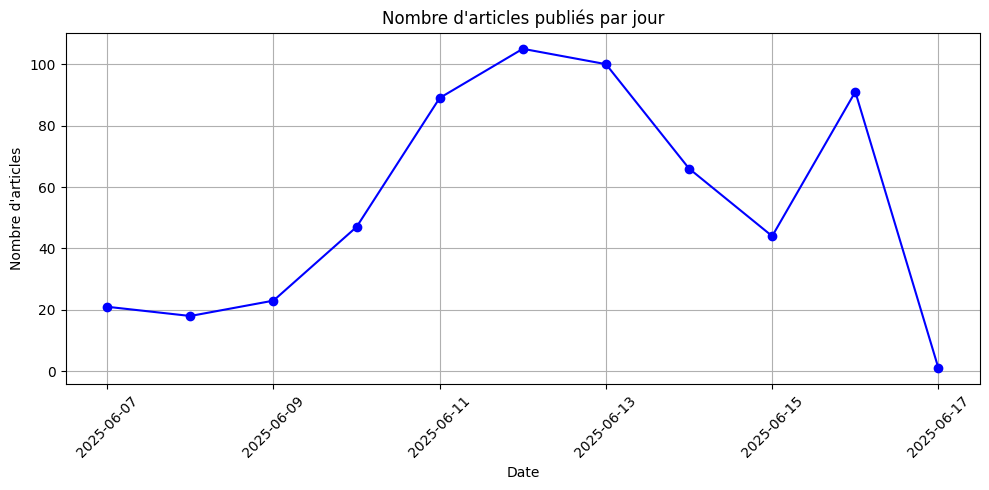

In [62]:
df['date_only'] = df['date'].dt.date
articles_par_jour = df.groupby('date_only').size()
plt.figure(figsize=(10, 5))
articles_par_jour.plot(kind='line', marker='o', color='blue')
plt.title("Nombre d'articles publiés par jour")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.5 Nombre d'articles par jour par source

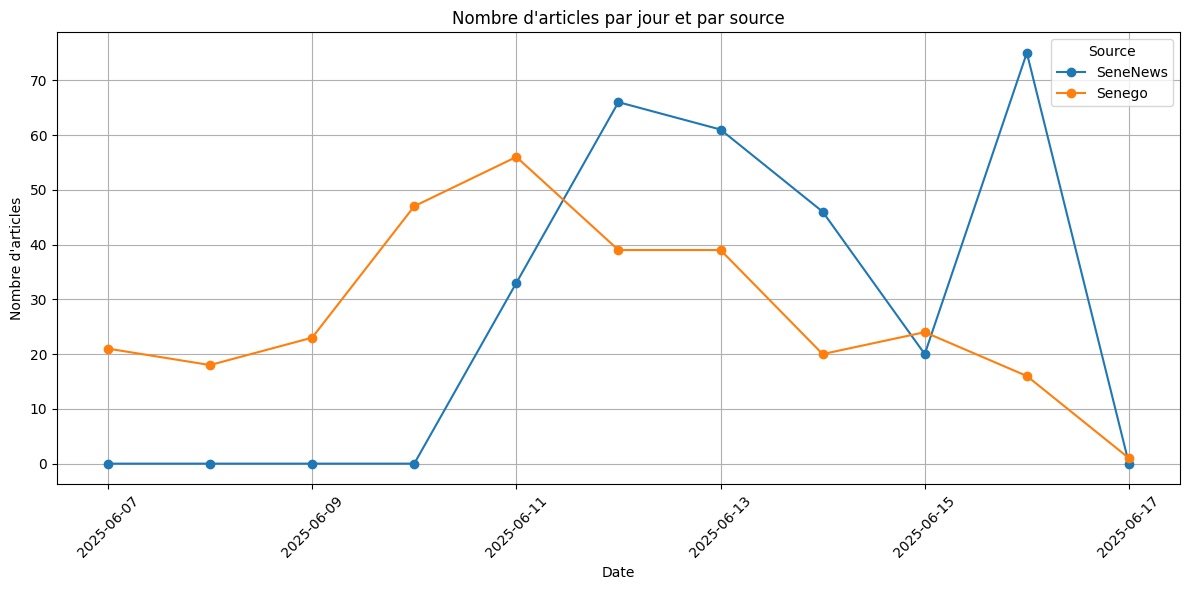

In [63]:
df['date_only'] = df['date'].dt.date
articles_jour_source = df.groupby(['date_only', 'source']).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
for source in articles_jour_source.columns:
    plt.plot(articles_jour_source.index, articles_jour_source[source], marker='o', label=source)

plt.title("Nombre d'articles par jour et par source")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.grid(True)
plt.tight_layout()
plt.show()


## 1.5 Nombre d'articles par jour par rubrique

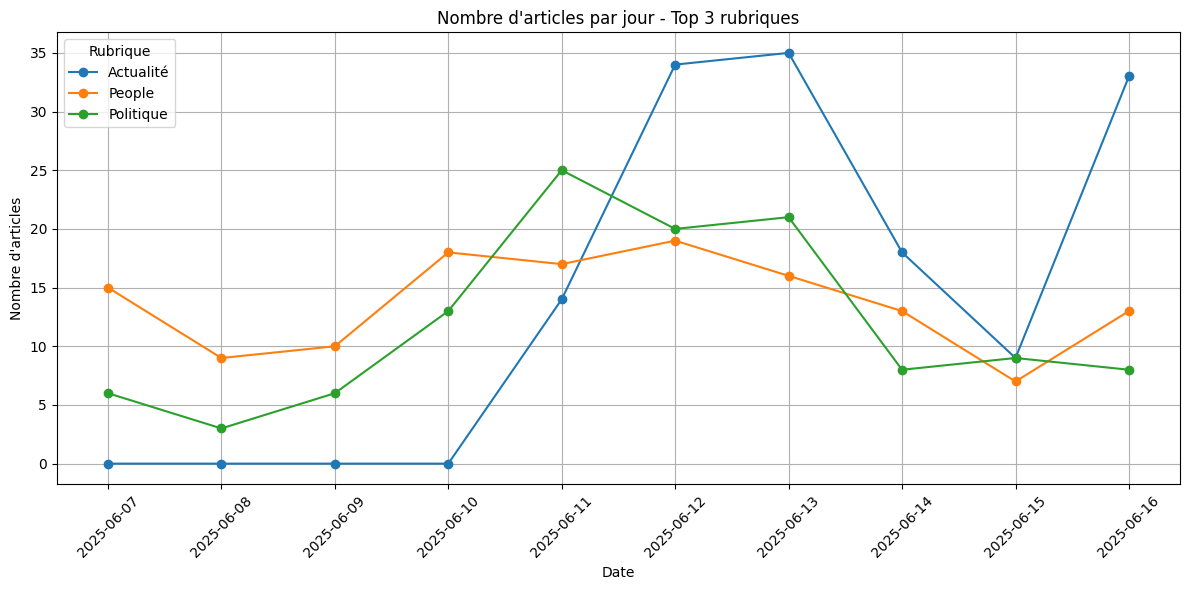

In [64]:
df['date_only'] = df['date'].dt.date

# Calcul total des articles par rubrique (theme)
total_par_theme = df['theme'].value_counts()

# Top 5 rubriques
top5_themes = total_par_theme.head(3).index.tolist()

# Filtrer le DataFrame pour ne garder que ces rubriques
df_top5 = df[df['theme'].isin(top5_themes)]

# Grouper par date et thème, puis pivoter
articles_jour_theme_top5 = df_top5.groupby(['date_only', 'theme']).size().unstack(fill_value=0)

# Tracer le lineplot
plt.figure(figsize=(12,6))
for theme in articles_jour_theme_top5.columns:
    plt.plot(articles_jour_theme_top5.index, articles_jour_theme_top5[theme], marker='o', label=theme)

plt.title("Nombre d'articles par jour - Top 3 rubriques")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.legend(title='Rubrique')
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.6 Histogramme du nombre de mots

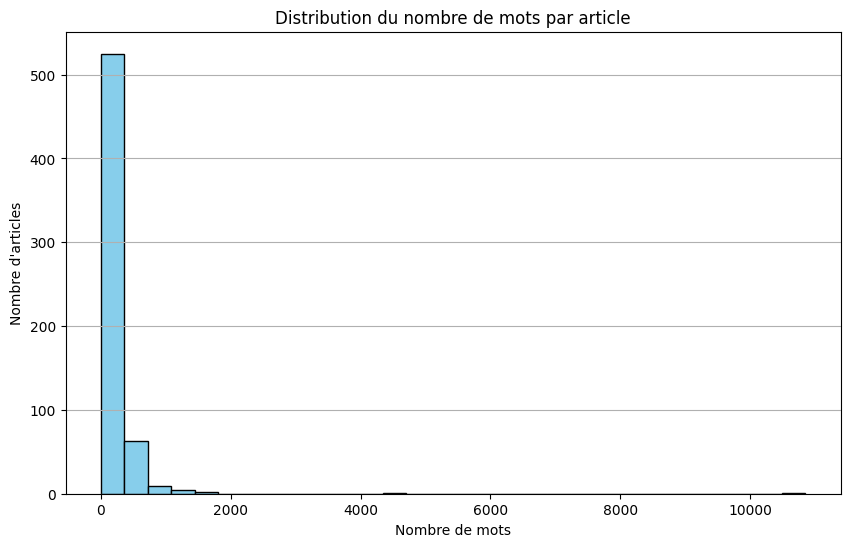

In [65]:
# Remplacer les NaN par chaîne vide
df['contenu_clean'] = df['contenu'].fillna('')

# Calculer le nombre de mots
df['nb_mots'] = df['contenu_clean'].str.split().apply(len)

plt.figure(figsize=(10,6))
plt.hist(df['nb_mots'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution du nombre de mots par article")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.grid(axis='y')
plt.show()


# 2. Topic Modeling

In [66]:
# Télécharger les stopwords français
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to C:\Users\Ahmed
[nltk_data]     Firhoun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# Fusionner les stopwords : WordCloud + NLTK + tes mots perso
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('french'))
custom_stopwords.update(ENGLISH_STOP_WORDS)  # Parfois utile si mélange anglais/français

# Ajouter tes propres mots
custom_stopwords.update([
    'selon', 'ce', 'cet', 'cette', 'dont', 'ainsi', 'hgroupe', 'ete', 'aussi','field','plus',
    'dun', 'dune', 'cest', 'comme', 'juin', 'apres', 'deux', 'senegal','senegalais','juingroupe',
    'sest','lors','egalement','sans','notamment', 'quil', 'tout', 'tous', 'fait','entre',
    'titre','plusieurs','sous','faire','bien','meme','avant','toujours','cela','face','tres',
    'leur','leurs','toute','toutes','vers','quelle','jai','etait','etais','senegalaise',
    'alors','encore','avoir','nest', 'etre',
    ])

## 2.1 Preprocessing

In [68]:
def preprocess(text):
    text = str(text).lower()                      # minuscules
    text = unidecode(text)                        # enlever les accents
    text = text.replace("'", " ")                 # remplacer les apostrophes par des espaces
    text = re.sub(r'\d+', '', text)               # enlever les chiffres
    text = re.sub(r'[^\w\s]', '', text)           # enlever la ponctuation sauf apostrophes déjà traitées
    tokens = text.split()                         # tokenisation simple
    tokens = [word for word in tokens if word not in custom_stopwords and len(word) > 2]
    return ' '.join(tokens)

# Application
df['cleaned_content'] = df['contenu'].apply(preprocess)


In [69]:
df['cleaned_content'].head()

0    federation guineenne football feguifoot offici...
1    communique officiel autorites senegalaises con...
2    tension reste vive moyenorient flash info jaze...
3    ameth babou prytanee militaire saintlouis sacr...
4    lachinea exprime lundi profonde preoccupation ...
Name: cleaned_content, dtype: object

## 2.2 Vectorisation

In [70]:
# Créer un vecteur de type Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2)  # on ignore les mots trop fréquents et trop rares
X = vectorizer.fit_transform(df['cleaned_content'])

# Afficher la taille du vocabulaire
print(f"Nombre de mots uniques retenus : {len(vectorizer.get_feature_names_out())}")

Nombre de mots uniques retenus : 5794


## 2.3 Analyse exploratoire

### 2.3.1 Mots les plus fréquents

In [71]:
# Compter tous les mots du corpus nettoyé
all_words = ' '.join(df['cleaned_content']).split()
word_freq = Counter(all_words)

# Afficher les 20 mots les plus fréquents
print("Mots les plus fréquents (corpus global) :\n")
for word, freq in word_freq.most_common(50):
    print(f"{word}: {freq}")

Mots les plus fréquents (corpus global) :

stadium: 492
president: 230
city: 229
ministre: 215
etat: 197
pays: 179
contre: 161
seattle: 155
ministere: 150
monde: 142
inter: 139
premier: 131
dakar: 128
ans: 126
los: 120
angeles: 120
nationale: 119
miami: 117
kawtef: 115
national: 114
nomme: 114
football: 112
ndiaye: 111
lincoln: 111
financial: 111
philadelphie: 111
place: 110
madrid: 110
rose: 107
republique: 107
bowl: 106
chef: 105
lumen: 105
politique: 104
ancien: 103
hard: 102
rock: 102
monsieur: 100
moustapha: 99
situation: 99
faye: 96
remplacement: 96
autorites: 95
depuis: 95
nouvelle: 94
real: 94
new: 93
club: 92
autres: 91
atil: 91


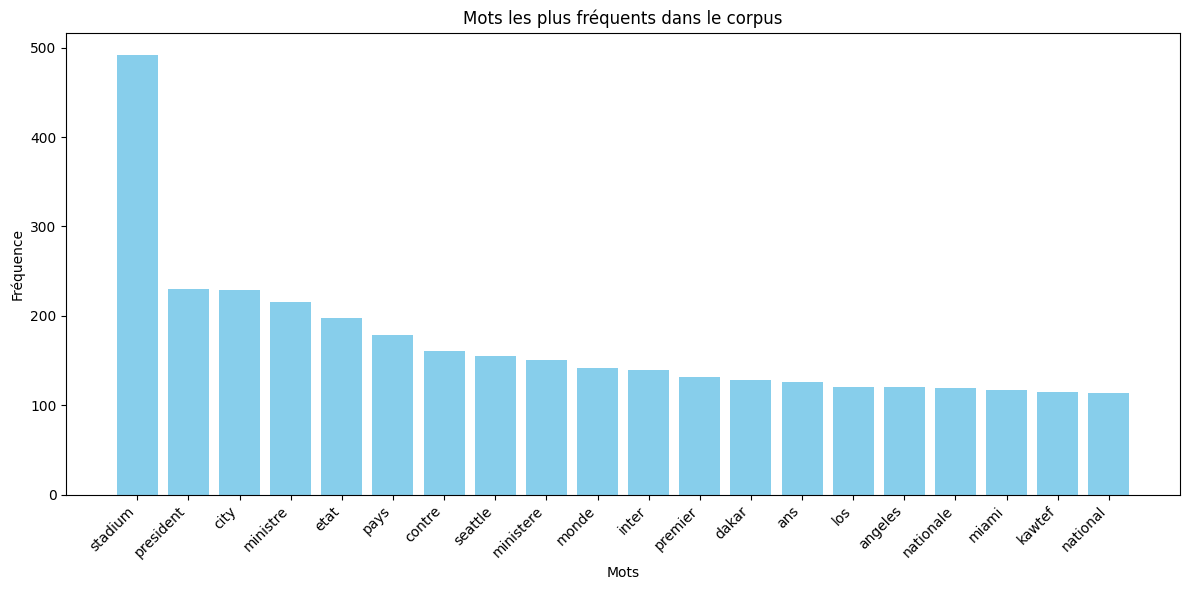

In [72]:
# Sélectionner les 20 mots les plus fréquents
most_common_words = word_freq.most_common(20)
words, freqs = zip(*most_common_words)

# Tracer le graphique
plt.figure(figsize=(12, 6))
plt.bar(words, freqs, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Mots les plus fréquents dans le corpus')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

### 2.3.2 Nuage des mots

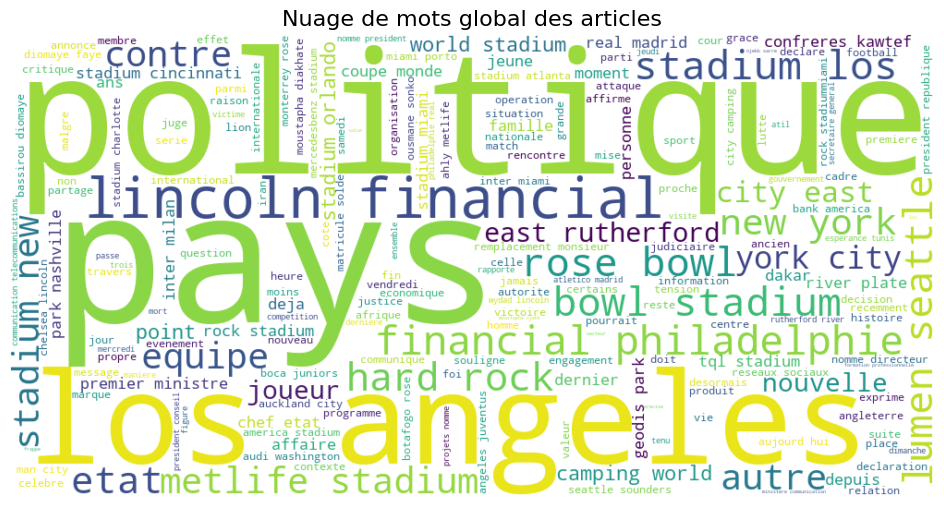

In [73]:
# Combiner tout le texte nettoyé
text_total = ' '.join(df['cleaned_content'])

# Générer le nuage de mots
wordcloud_global = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords='french',
    max_words=200
).generate(text_total)

# Afficher le nuage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_global, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots global des articles", fontsize=16)
plt.show()


## 2.4 Topic Modeling avec Latent Dirichlet Allocation (LDA)

In [74]:
# Chargement du modèle LDA
best_lda = joblib.load('./models/best_lda_model.joblib')
vectorizer = joblib.load('./models/vectorizer.joblib')

In [ ]:
# Vectorisation
X = vectorizer.transform(df['cleaned_content'])

### 2.4.2 Nombre d'articles par Topic

In [76]:
# Obtenir la distribution des topics par document
topic_distribution = best_lda.transform(X)

# Ajouter le topic dominant dans le DataFrame
df['topic'] = topic_distribution.argmax(axis=1)

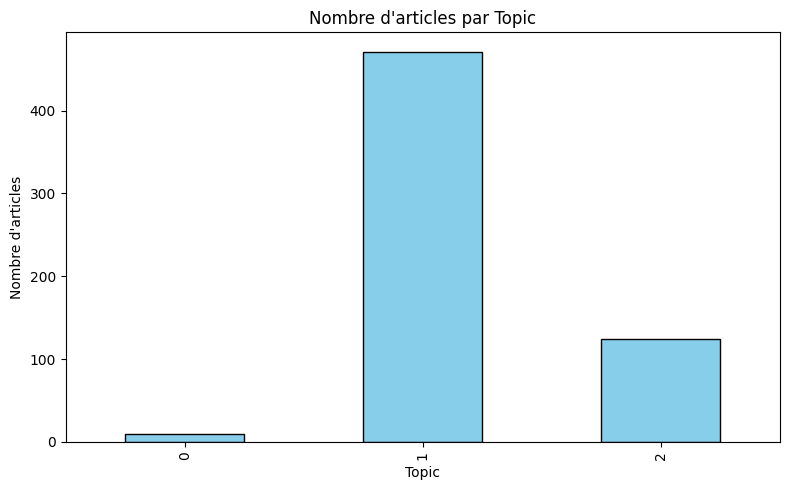

In [77]:
compte_topic = df['topic'].value_counts().sort_index()

# Afficher le graphique
plt.figure(figsize=(8, 5))
compte_topic.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'articles par Topic")
plt.xlabel("Topic")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

### 2.4.3 Différents topic avec les mots les plus fréquents ressortis

In [78]:
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n Topic {topic_idx + 1}")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(best_lda, vectorizer.get_feature_names_out())



 Topic 1
stadium, city, angeles, los, miami, inter, madrid, rose, new, york

 Topic 2
president, ministre, pays, contre, ministere, monde, kawtef, premier, letat, nomme

 Topic 3
ans, club, cours, tribunal, enquete, autorites, securite, drame, direction, strasbourg


In [79]:
# Compter les mots par topic
for topic in sorted(df['topic'].unique()):
    all_topic_words = ' '.join(df[df['topic'] == topic]['cleaned_content']).split()
    topic_freq = Counter(all_topic_words)
    print(f"\n Topic {topic} - mots les plus fréquents :")
    for word, freq in topic_freq.most_common(10):
        print(f"{word}: {freq}")


 Topic 0 - mots les plus fréquents :
stadium: 485
city: 208
seattle: 155
los: 115
angeles: 115
inter: 115
miami: 114
lincoln: 111
financial: 111
philadelphie: 111

 Topic 1 - mots les plus fréquents :
president: 226
ministre: 194
etat: 165
pays: 149
contre: 134
ministere: 133
monde: 118
nomme: 114
premier: 111
football: 104

 Topic 2 - mots les plus fréquents :
enquete: 68
ans: 46
accident: 43
club: 42
cours: 37
autorites: 35
drame: 33
securite: 32
direction: 32
etat: 32


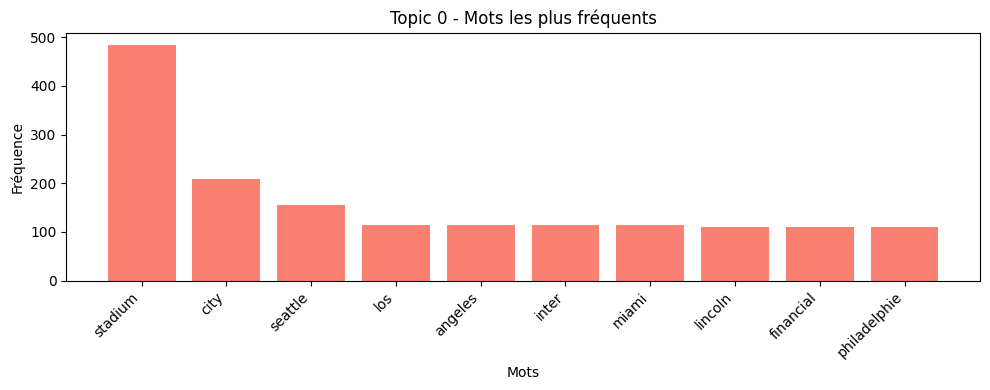

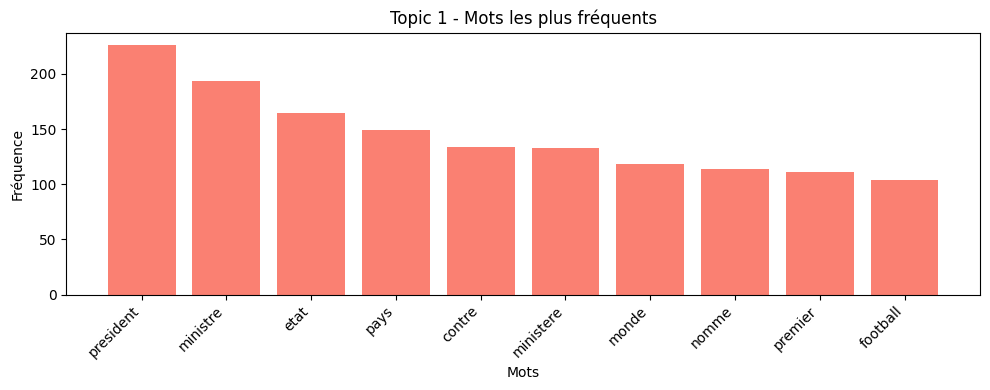

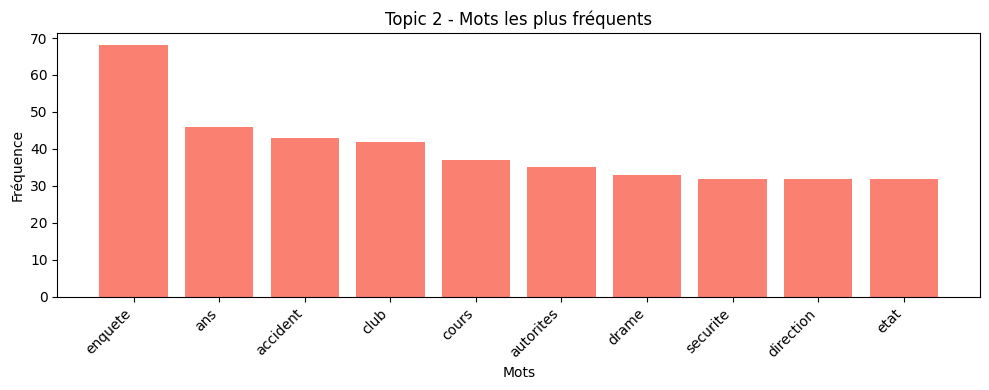

In [80]:
# Définir le nombre de mots à afficher
TOP_N = 10

# Itérer sur les topics
for topic in sorted(df['topic'].unique()):
    all_topic_words = ' '.join(df[df['topic'] == topic]['cleaned_content']).split()
    topic_freq = Counter(all_topic_words)
    most_common = topic_freq.most_common(TOP_N)

    if most_common:  # Vérifie qu'il y a bien du texte
        words, freqs = zip(*most_common)

        # Tracer le graphique
        plt.figure(figsize=(10, 4))
        plt.bar(words, freqs, color='salmon')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Topic {topic} - Mots les plus fréquents')
        plt.xlabel('Mots')
        plt.ylabel('Fréquence')
        plt.tight_layout()
        plt.show()


### 2.4.5 Nuage de mots par Topic

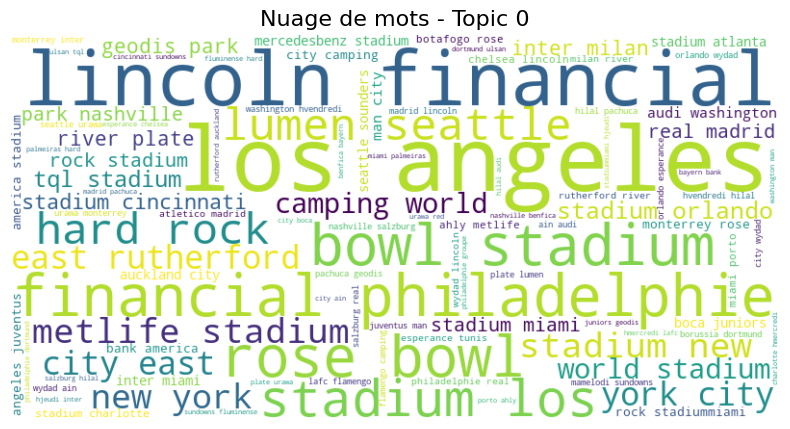

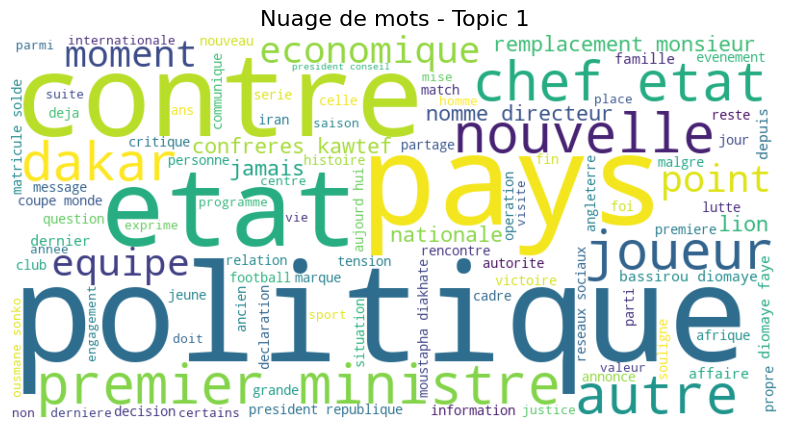

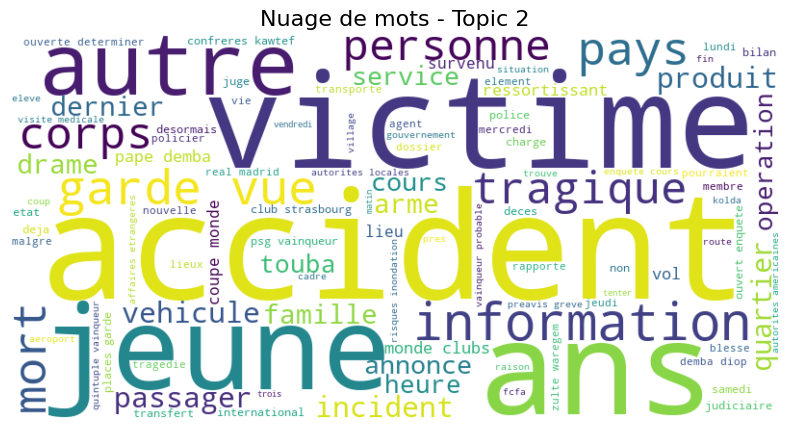

In [81]:
# Créer un nuage de mots pour chaque topic
for topic_num in sorted(df['topic'].unique()):
    texts = df[df['topic'] == topic_num]['cleaned_content']
    text_combined = ' '.join(texts)

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords='french', max_words=100).generate(text_combined)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuage de mots - Topic {topic_num}', fontsize=16)
    plt.show()


### 2.4.6 Rubriques par Topic

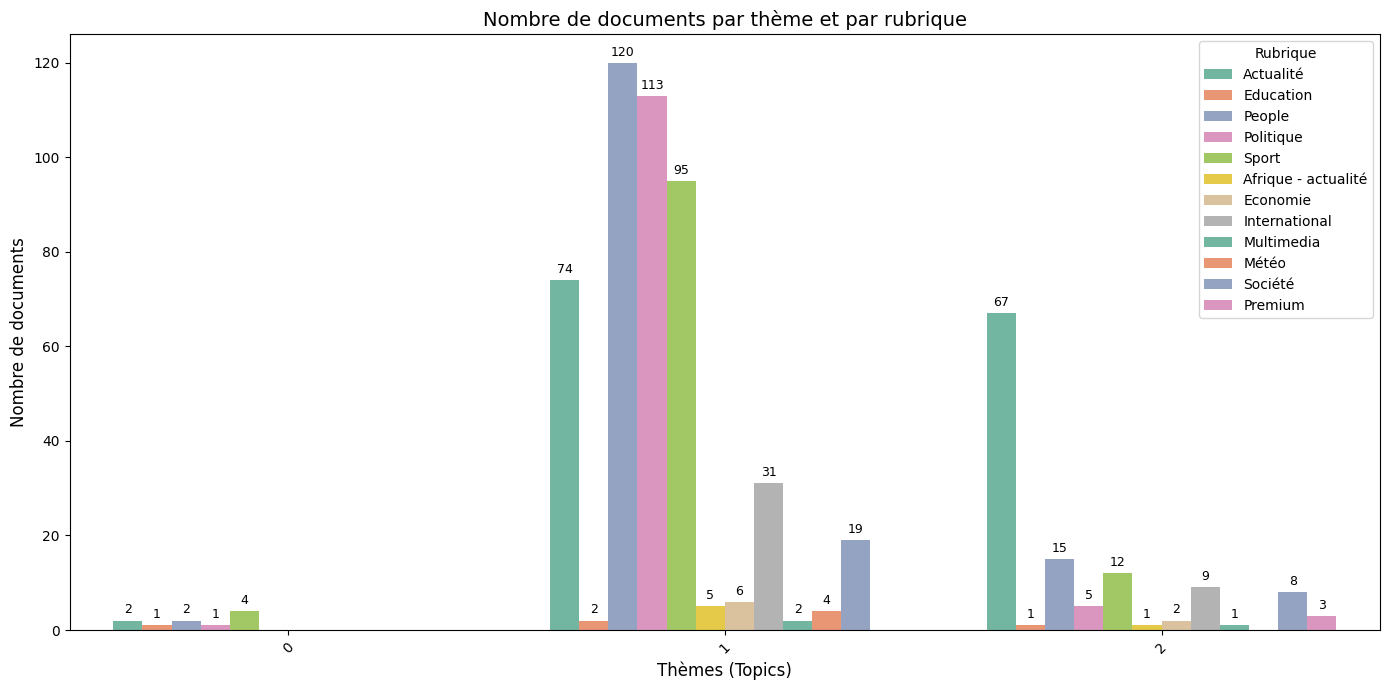

In [82]:
# Créer un tableau de contingence rubrique vs topic
rubrique_topic_counts = df.groupby(['topic', 'theme']).size().reset_index(name='Nombre de documents')
# Créer la figure
plt.figure(figsize=(14, 7))

# Barplot avec palette claire
ax = sns.barplot(
    data=rubrique_topic_counts,  # ton DataFrame regroupé
    x='topic',
    y='Nombre de documents',
    hue='theme',
    palette='Set2'
)

# Ajouter les annotations (valeurs) sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3)

# Améliorer les labels et la lisibilité
plt.xlabel("Thèmes (Topics)", fontsize=12)
plt.ylabel("Nombre de documents", fontsize=12)
plt.title("Nombre de documents par thème et par rubrique", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Rubrique")

plt.show()



### 2.4.7 Quelques statistiques descriptives par Topic

In [83]:
# Regroupement par topic dominant
grouped = df.groupby('topic')

stats = pd.DataFrame({
    'Nombre d\'articles': grouped.size(),
    'Proportion du corpus(%)': grouped.size() / len(df) * 100,
    'Longueur moyenne (mots)': grouped['nb_mots'].mean(),
    'Date min': grouped['date'].min(),
    'Date max': grouped['date'].max()
})

# Calcul de l'étendue en jours
stats['Etendue (jours)'] = (stats['Date max'] - stats['Date min']).dt.days

stats.head()


,Nombre d'articles,Proportion du corpus(%),Longueur moyenne (mots),Date min,Date max,Etendue (jours)
topic,,,,,,
0,10,1.652893,1226.500000,2025-06-12 16:58:00,2025-06-16 22:30:00,4
1,471,77.851240,219.278132,2025-06-07 08:50:00,2025-06-17 06:30:00,9
2,124,20.495868,180.717742,2025-06-08 09:59:00,2025-06-16 23:42:00,8


In [84]:
# Afficher la distribution des thèmes par topic
print("\nDistribution des thèmes par topic :")
for topic, group in grouped:
    print(f"\nTopic {topic}:")
    print(group['theme'].value_counts())


Distribution des thèmes par topic :

Topic 0:
theme
Sport        4
People       2
Actualité    2
Education    1
Politique    1
Name: count, dtype: int64

Topic 1:
theme
People                 120
Politique              113
Sport                   95
Actualité               74
International           31
Société                 19
Economie                 6
Afrique - actualité      5
Météo                    4
Education                2
Multimedia               2
Name: count, dtype: int64

Topic 2:
theme
Actualité              67
People                 15
Sport                  12
International           9
Société                 8
Politique               5
Premium                 3
Economie                2
Education               1
Afrique - actualité     1
Multimedia              1
Name: count, dtype: int64


### 2.4.8 Tableau de bord final

In [85]:
panel = pyLDAvis.lda_model.prepare(best_lda, X, vectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\Ahmed Firhoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ahmed Firhoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
